In [2]:
# Import libraries

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrix
import datetime
from scipy.stats import chisquare

# Pretty display for notebooks

%matplotlib inline


# Allows the use of display() for DataFrames
from IPython.display import display 

# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
train = pd.read_csv("../asset/train.csv")
test = pd.read_csv("../asset/test.csv")
weather = pd.read_csv("../asset/weather.csv")
key = pd.read_csv("../asset/key.csv")
submission_example = pd.read_csv("../asset/sampleSubmission.csv")

# Success - Display the first record
print("Train data : ", train.shape)
print("Test  data : ", test.shape)
print("weather  data : ", weather.shape)
print("key  data : ", key.shape)
print("submission  data : ", submission_example.shape)

coulmns_should_be_integer_type_of_data = ["tmax", "tmin", "tavg", "dewpoint", "wetbulb", "heat", "cool"]
coulmns_should_be_float_type_of_data = ["snowfall", "preciptotal", "stnpressure", "sealevel", "depart",\
                                        "resultspeed", "resultdir", "avgspeed"]

import pickle
import costum_functions as cf

# 원본을 유지하기 위해서 카피
df_train = train.copy()
df_weather = weather.copy()
df_key = key.copy()
df_train_with_weather = pd.read_csv("df_train_with_weather_201806251508.csv")

def addDays(date):
    temp = date.split("-")
    year, month, date = int(temp[0]), int(temp[1]), int(temp[2])
    return datetime.datetime(year, month, date).weekday()
df_train_with_weather["day"] = df_train_with_weather["date"].apply(addDays)

Train data :  (4617600, 4)
Test  data :  (526917, 3)
weather  data :  (20517, 20)
key  data :  (45, 2)
submission  data :  (526917, 2)


In [6]:
def changeTypeToInt(a):
    temp = str(a).strip()
    if temp == 'M' or temp == '-':
        return np.nan
    else:
        return int(a)
    
def changeTypeToFloat(a):
    temp = str(a).strip()
    if temp == 'M':
        return np.nan
    elif temp == 'T' or temp == '-':
        return 0
    else:
        return float(a)
    
def remove_m_row(df, columns = []):
    """
        m_row를 제거할 data_frame 파일을 df 패러미터로 넣어준다.
        columns를 패러미터로 안넣어줄 경우에는 전체 컬럼의 m값을 날린다.
        columns를 넣어주는 경우에는 반드시 리스트로 넣어줄것!! 예:) ["tmax", "tmin"]
        그리고 처리된 df를 리턴하는 것이므로!! 원하는 변수명으로 받아줄 것
        예:) df_test = remove_m_row(df_weather, ["tmax", "tmin"])
    """
    result_df = df.copy()
    if len(columns) == 0:
        columns = result_df.columns
    cols_int = ["tmax", "tmin", "tavg", "dewpoint", "wetbulb", "heat", "cool"]
    cols_float = ["sunrise","sunset","snowfall", "preciptotal", "stnpressure", "sealevel", "depart", "resultspeed", "resultdir", "avgspeed"]
    for column in columns:
        print(column)
        if column in cols_int:
            result_df[column] = result_df[column].apply(changeTypeToInt)
        elif column in cols_float:
            result_df[column] = result_df[column].apply(changeTypeToFloat)
    return result_df.dropna()

In [7]:
station_11 = df_weather[df_weather["station_nbr"] == 11].reset_index(drop=True)
station_11.drop("snowfall", axis=1, inplace=True)
# station_11.drop("depart", axis=1, inplace=True)
station_11_only_dropped_t = remove_m_row(station_11, ["tmax", "tmin", "tavg","depart"])
station_11_dropped_all = remove_m_row(station_11)
station_11_t = station_11_only_dropped_t[["tmax","tmin","tavg","depart"]]
print("원래 station_11의 row 개수" + str(len(station_11)))
print("원래 t관련 컬럼의 m value를 포함한 row를 날린 후 전체 개수" + str(len(station_11_only_dropped_t)))
print("원래 전체 컬럼의 m value를 포함한 row를 날린 후 전체 개수" + str(len(station_11_dropped_all)))

tmax
tmin
tavg
depart
station_nbr
date
tmax
tmin
tavg
depart
dewpoint
wetbulb
heat
cool
sunrise
sunset
codesum
preciptotal
stnpressure
sealevel
resultspeed
resultdir
avgspeed
원래 station_11의 row 개수1035
원래 t관련 컬럼의 m value를 포함한 row를 날린 후 전체 개수1000
원래 전체 컬럼의 m value를 포함한 row를 날린 후 전체 개수934


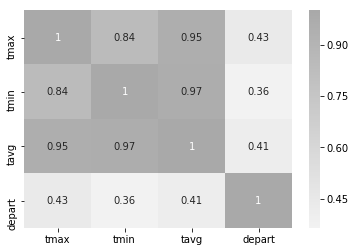

In [8]:
cmap = sns.light_palette("darkgray", as_cmap=True)
sns.heatmap(station_11_t.corr(), annot=True, cmap=cmap)
plt.show()

In [9]:
column = ["dewpoint", "wetbulb"]
station_11 = df_weather[df_weather["station_nbr"] == 11].reset_index(drop=True)
station_11.drop("snowfall", axis=1, inplace=True)
# station_11.drop("depart", axis=1, inplace=True)
station_11_only_dropped_t = remove_m_row(station_11, column)
station_11_dropped_all = remove_m_row(station_11)
station_11_t = station_11_only_dropped_t[column]
print("원래 station_11의 row 개수" + str(len(station_11)))
print("m value를 포함한 row를 날린 후 전체 개수" + str(len(station_11_only_dropped_t)))
print("원래 전체 컬럼의 m value를 포함한 row를 날린 후 전체 개수" + str(len(station_11_dropped_all)))

dewpoint
wetbulb
station_nbr
date
tmax
tmin
tavg
depart
dewpoint
wetbulb
heat
cool
sunrise
sunset
codesum
preciptotal
stnpressure
sealevel
resultspeed
resultdir
avgspeed
원래 station_11의 row 개수1035
m value를 포함한 row를 날린 후 전체 개수972
원래 전체 컬럼의 m value를 포함한 row를 날린 후 전체 개수934


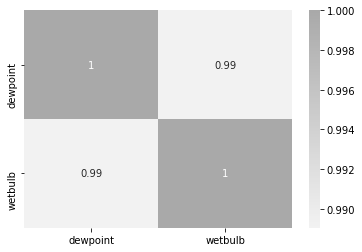

In [10]:
cmap = sns.light_palette("darkgray", as_cmap=True)
sns.heatmap(station_11_t.corr(), annot=True, cmap=cmap)
plt.show()

In [11]:
column = ["heat", "cool", "sunrise", "sunset"]
station_11 = df_weather[df_weather["station_nbr"] == 11].reset_index(drop=True)
station_11.drop("snowfall", axis=1, inplace=True)
# station_11.drop("depart", axis=1, inplace=True)
station_11_only_dropped_t = remove_m_row(station_11, column)
# station_11_dropped_all = remove_m_row(station_11)
station_11_t = station_11_only_dropped_t[column]
print("원래 station_11의 row 개수" + str(len(station_11)))
print("m value를 포함한 row를 날린 후 전체 개수" + str(len(station_11_only_dropped_t)))
# print("원래 전체 컬럼의 m value를 포함한 row를 날린 후 전체 개수" + str(len(station_11_dropped_all)))

heat
cool
sunrise
sunset
원래 station_11의 row 개수1035
m value를 포함한 row를 날린 후 전체 개수1031


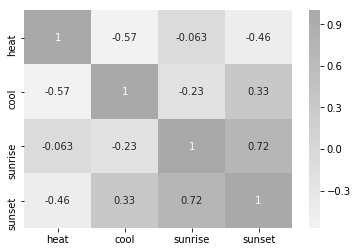

In [12]:
# np.astype(station_11_t[["sunrise","sunset"]],float)
cmap = sns.light_palette("darkgray", as_cmap=True)
sns.heatmap(station_11_t.corr(), annot=True, cmap=cmap)
plt.show()

In [13]:
column = ["snowfall", "preciptotal"]
station_11 = df_weather[df_weather["station_nbr"] == 11].reset_index(drop=True)
# station_11.drop("snowfall", axis=1, inplace=True)
# station_11.drop("depart", axis=1, inplace=True)
station_11_only_dropped_t = remove_m_row(station_11, column)
station_11_dropped_all = remove_m_row(station_11)
station_11_t = station_11_only_dropped_t[column]
print("원래 station_11의 row 개수" + str(len(station_11)))
print("m value를 포함한 row를 날린 후 전체 개수" + str(len(station_11_only_dropped_t)))
print("원래 전체 컬럼의 m value를 포함한 row를 날린 후 전체 개수" + str(len(station_11_dropped_all)))

snowfall
preciptotal
station_nbr
date
tmax
tmin
tavg
depart
dewpoint
wetbulb
heat
cool
sunrise
sunset
codesum
snowfall
preciptotal
stnpressure
sealevel
resultspeed
resultdir
avgspeed
원래 station_11의 row 개수1035
m value를 포함한 row를 날린 후 전체 개수1032
원래 전체 컬럼의 m value를 포함한 row를 날린 후 전체 개수932


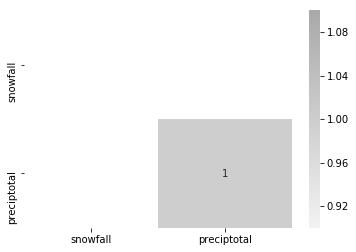

In [14]:
cmap = sns.light_palette("darkgray", as_cmap=True)
sns.heatmap(station_11_t.corr(), annot=True, cmap=cmap)
plt.show()

In [15]:
column = ["stnpressure", "sealevel"]
station_11 = df_weather[df_weather["station_nbr"] == 11].reset_index(drop=True)
# station_11.drop("snowfall", axis=1, inplace=True)
# station_11.drop("depart", axis=1, inplace=True)
station_11_only_dropped_t = remove_m_row(station_11, column)
station_11_dropped_all = remove_m_row(station_11)
station_11_t = station_11_only_dropped_t[column]
print("원래 station_11의 row 개수" + str(len(station_11)))
print("m value를 포함한 row를 날린 후 전체 개수" + str(len(station_11_only_dropped_t)))
print("원래 전체 컬럼의 m value를 포함한 row를 날린 후 전체 개수" + str(len(station_11_dropped_all)))

stnpressure
sealevel
station_nbr
date
tmax
tmin
tavg
depart
dewpoint
wetbulb
heat
cool
sunrise
sunset
codesum
snowfall
preciptotal
stnpressure
sealevel
resultspeed
resultdir
avgspeed
원래 station_11의 row 개수1035
m value를 포함한 row를 날린 후 전체 개수971
원래 전체 컬럼의 m value를 포함한 row를 날린 후 전체 개수932


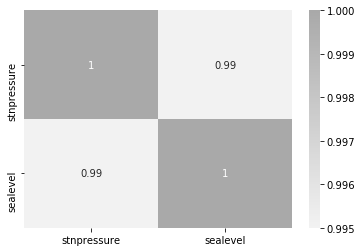

In [16]:
cmap = sns.light_palette("darkgray", as_cmap=True)
sns.heatmap(station_11_t.corr(), annot=True, cmap=cmap)
plt.show()

In [17]:
column = ["resultspeed", "resultdir", "avgspeed"]
station_11 = df_weather[df_weather["station_nbr"] == 11].reset_index(drop=True)
# station_11.drop("snowfall", axis=1, inplace=True)
# station_11.drop("depart", axis=1, inplace=True)
station_11_only_dropped_t = remove_m_row(station_11, column)
station_11_dropped_all = remove_m_row(station_11)
station_11_t = station_11_only_dropped_t[column]
print("원래 station_11의 row 개수" + str(len(station_11)))
print("m value를 포함한 row를 날린 후 전체 개수" + str(len(station_11_only_dropped_t)))
print("원래 전체 컬럼의 m value를 포함한 row를 날린 후 전체 개수" + str(len(station_11_dropped_all)))

resultspeed
resultdir
avgspeed
station_nbr
date
tmax
tmin
tavg
depart
dewpoint
wetbulb
heat
cool
sunrise
sunset
codesum
snowfall
preciptotal
stnpressure
sealevel
resultspeed
resultdir
avgspeed
원래 station_11의 row 개수1035
m value를 포함한 row를 날린 후 전체 개수973
원래 전체 컬럼의 m value를 포함한 row를 날린 후 전체 개수932


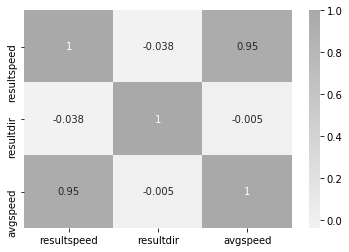

In [18]:
cmap = sns.light_palette("darkgray", as_cmap=True)
sns.heatmap(station_11_t.corr(), annot=True, cmap=cmap)
plt.show()